Mapping Labels for Embedded IDs: 2744489it [02:12, 20741.19it/s]
c:\Users\manas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Accuracy: 86.06%
🎯 Precision (macro): 0.85
📥 Recall (macro): 0.83

📊 Classification Report:

              precision    recall  f1-score   support

          AI       0.71      0.53      0.61      5411
          CV       0.91      0.93      0.92     23952
          DS       0.90      0.88      0.89      3313
          ML       0.83      0.84      0.83     21134
         NLP       0.86      0.90      0.88     12801
  Networking       0.88      0.88      0.88      3457
          SE       0.86      0.86      0.86      3211
    Security       0.83      0.84      0.84      5277

    accuracy                           0.86     78556
   macro avg       0.85      0.83      0.84     78556
weighted avg       0.86      0.86      0.86     78556



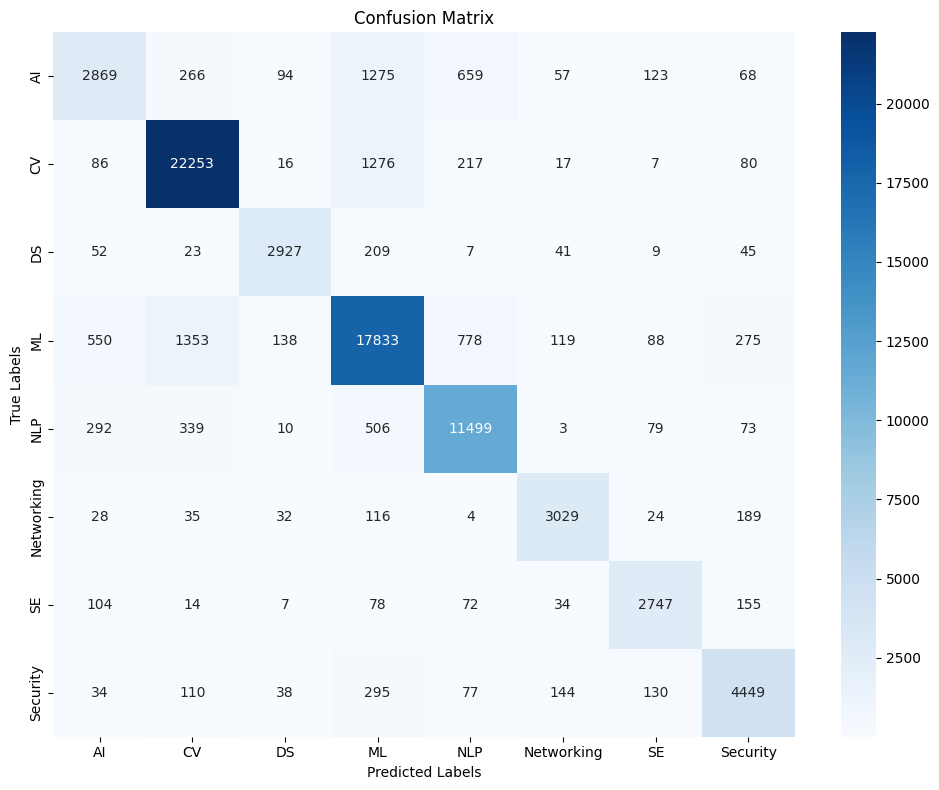

In [ ]:
import json
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

with open("../model/arxiv_embeddings.pkl", "rb") as f:
    data = pickle.load(f)
    ids = data["ids"]
    texts = data["texts"]
    embeddings = data["embeddings"]

embedded_ids_set = set(ids)
id_to_label = {}

with open("../arxiv-metadata-oai-snapshot.json", 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Mapping Labels for Embedded IDs"):
        record = json.loads(line)
        record_id = record.get("id", "")
        if record_id in embedded_ids_set and "cs." in record.get("categories", ""):
            full_category = record["categories"].split()[0]
            id_to_label[record_id] = full_category

category_map = {
    'cs.AI': 'AI',
    'cs.CL': 'NLP',
    'cs.LG': 'ML',
    'cs.CV': 'CV',
    'cs.SE': 'SE',
    'cs.DS': 'DS',
    'cs.NI': 'Networking',
    'cs.CR': 'Security'
}

labels = []
final_texts = []
final_embeddings = []

for idx, paper_id in enumerate(ids):
    if paper_id in id_to_label:
        cat = id_to_label[paper_id]
        general_label = category_map.get(cat)
        if general_label:
            labels.append(general_label)
            final_texts.append(texts[idx])
            final_embeddings.append(embeddings[idx])

final_embeddings = np.array(final_embeddings)

X_train, X_test, y_train, y_test = train_test_split(
    final_embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
conf_mat = confusion_matrix(y_test, y_pred)

print(f"✅ Accuracy: {accuracy*100:.2f}%")
print(f"🎯 Precision (macro): {precision:.2f}")
print(f"📥 Recall (macro): {recall:.2f}")
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()
